In [1]:
import os
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors
import numpy as np
import random

## Reference
Li, Chen, et al. "Mux-Kmeans: Multiplex Kmeans for Clustering Large-Scale Data Set." *Proceedings of the 5th ACM Workshop on Scientific Cloud Computing (ScienceCloud'14)*, 23–27 June 2014, Vancouver, BC, Canada, ACM, 2014, pp. 1-7. https://doi.org/10.1145/2608029.2608033

## Adaptation
1. The algorithm was converted from map-reduce to spark
2. The algorithm was adapted to parallelize all the heavy computations including the cluster assignment and twcv
3. The TWCV is calculated in parallel utilizing the rdd

# TWCV Calculation Function

### What is TWCV?
The **Total Within-Cluster Variation (TWCV)** is a measure of the clustering quality. It calculates the sum of squared Euclidean distances between each data point and the centroid of its assigned cluster. A lower TWCV indicates better clustering as the points are closer to their respective centroids.

### Formula
$$
\text{TWCV} = \sum_{j=1}^K \sum_{x_i \in C_j} \| x_i - c_j \|^2
$$
Where:
- $( K )$: Number of clusters.
- $( C_j)$: Set of data points assigned to the $j$-th cluster.
- $( x_i)$: Data point in cluster $( C_j )$.
- $( c_j)$: Centroid of the $( j )$-th cluster.
- $( | x_i - c_j |^2 )$: Squared Euclidean distance between the data point $( x_i )$ and the centroid $( c_j $).

In [2]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Mux-Kmeans") \
    .getOrCreate()

sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/29 13:19:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [23]:
def calculate_similarity(group1, group2):
    """
    Calculate the similarity score between two centroid groups.
    The similarity is the inverse of the sum of distances between corresponding centroids.
    """
    distances = [np.linalg.norm(c1 - c2) for c1, c2 in zip(group1, group2)]
    return 1 / sum(distances) if sum(distances) != 0 else float('inf')


def find_most_dissimilar_group(target_group, groups):
    """
    Find the most dissimilar group to the target group.
    """
    max_dissimilarity = -float('inf')
    most_dissimilar = None
    
    for group in groups:
        if np.array_equal(target_group, group):
            continue  # Skip self-comparison
        
        similarity = calculate_similarity(target_group, group)
        if similarity > max_dissimilarity:
            max_dissimilarity = similarity
            most_dissimilar = group
    
    return most_dissimilar


def adgp(groups):
    """
    Generate new centroid groups using the Average of Dissimilar Group Pairs (ADGP).
    """
    new_groups = []
    group_count = len(groups)
    
    for i, group1 in enumerate(groups):
        group2 = find_most_dissimilar_group(group1, groups)
        
        # Compute the average of corresponding centroids to form a new group
        new_group = [(c1 + c2) / 2 for c1, c2 in zip(group1, group2)]
        new_groups.append(new_group)
    
    return new_groups

# Permutation function to align centroids across groups
def permute_centroids(centroid_groups):
    base_group = centroid_groups[0]
    permuted_groups = []

    for group in centroid_groups[1:]:
        # Track matched indices to prevent duplication
        matched = set()
        permuted_group = []
        for base_c in base_group:
            # Find the closest unmatched centroid
            distances = [(i, np.linalg.norm(base_c - c)) for i, c in enumerate(group) if i not in matched]
            if distances:
                closest_idx = min(distances, key=lambda x: x[1])[0]
                permuted_group.append(group[closest_idx])
                matched.add(closest_idx)
            else:
                # Handle unmatched cases by using a default
                permuted_group.append(base_c)
        permuted_groups.append(permuted_group)
    return [base_group] + permuted_groups

In [20]:
A3_DATASET_URL = "https://cs.joensuu.fi/sipu/datasets/a3.txt"
DATA_FOLDER = "/home/jovyan/work/data"
A3_LOCAL_PATH = os.path.join(DATA_FOLDER, "a3.txt")

k = 50  # Number of clusters
s = 10  # Number of centroid groups
max_iterations = 20
num_partitions = 10


# Download Data
if not os.path.exists(A3_LOCAL_PATH):
    with open(A3_LOCAL_PATH, 'wb') as file:
        response = requests.get(A3_DATASET_URL)
        file.write(response.content)

# Load clean data into spark
data = sc.textFile(A3_LOCAL_PATH)
parsed_data = data.map(lambda row: np.array([float(x) for x in row.strip().split()])).repartition(num_partitions).cache()

parsed_data.take(5)

[array([53769., 43786.]),
 array([52883., 41365.]),
 array([54448., 42846.]),
 array([53358., 40498.]),
 array([54626., 43461.])]

In [21]:
# Initialize multiple centroid groups
def initialize_centroid_groups(parsed_data, k, s):
    # Collect a small subset of the data for initialization
    sample_data = parsed_data.takeSample(False, k * s, seed=1)
    centroid_groups = [
        sample_data[i * k:(i + 1) * k] for i in range(s)
    ]
    return centroid_groups

# Initialize centroid groups
initial_centroids_groups = initialize_centroid_groups(parsed_data, k, s)

# Mux-Kmeans main loop
for iteration in range(max_iterations):
    twcv_scores = []
    cluster_assignments = []
    cluster_points = []
    
    # Evaluate centroid groups
    for centroids in initial_centroids_groups:
        centroids_broadcast = sc.broadcast(centroids)

        # Assign points to clusters
        clustered_rdd = parsed_data.map(
            lambda p: (
                np.argmin([np.linalg.norm(p - c) for c in centroids_broadcast.value]),
                (p, 1)
            )
        )

        # Recalculate centroids
        new_centroids = (
            clustered_rdd
            .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))  # Sum points and count
            .map(lambda x: (x[0], x[1][0] / x[1][1]))  # Compute new centroids
            .collectAsMap()
        )
        
        new_centroids_arr = np.array(
                [new_centroids[j] if j in new_centroids else centroids[j] for j in range(len(centroids))]
        )

        # Update the centroids to the new centroids
        centroids_broadcast = sc.broadcast(new_centroids_arr)
        
        # Assign points to the nearest new centroids
        centroid_to_point = parsed_data.map(
            lambda point: (
                np.argmin([np.linalg.norm(point - c) for c in centroids_broadcast.value]), # cluster_id
                point # original point
            )
        )

        # Calculate TWCV for the current group
        # Row is (cluster_id, point)
        twcv = centroid_to_point.map(lambda row: np.linalg.norm(row[1] - centroids_broadcast.value[row[0]]) ** 2).sum()
        twcv_scores.append((new_centroids_arr, twcv))

    # Prune and incubate
    twcv_scores.sort(key=lambda x: x[1])
    best_groups = twcv_scores[:s // 2]
    best_centroids = [x[0] for x in best_groups]

    # Permutation
    aligned_centroid_groups = permute_centroids(best_centroids)
    
    # Incubate new groups
    new_centroid_groups = []
    for group in aligned_centroid_groups:
        new_centroid_groups.append(adgp(group))

    # Prepare for the next iteration
    initial_centroids_groups = best_centroids + new_centroid_groups
    print("scores:", end="\t")
    for score in twcv_scores:
        print(f"{int(score[1]):,}", end="\t")
    print()
    

# Select the final best group
final_group = min(twcv_scores, key=lambda x: x[1])
print(f"Best TWCV: {final_group[1]}")
        

scores:	64,300,311,136	84,275,470,878	94,183,249,718	95,622,989,572	97,997,079,054	99,354,072,582	107,719,643,104	110,397,662,260	114,439,371,345	123,091,313,805	
scores:	50,186,498,844	56,648,240,049	74,079,606,634	76,175,584,832	76,544,836,466	86,369,889,378	89,250,272,155	105,776,542,718	107,690,554,255	121,683,614,818	
scores:	44,934,280,694	49,199,483,565	62,406,444,640	63,082,639,900	71,147,591,168	78,067,216,810	85,373,091,719	86,110,071,297	97,666,886,463	114,522,772,972	
scores:	43,248,141,539	44,970,777,262	55,355,089,318	56,682,943,525	67,022,643,063	77,332,985,537	81,610,874,055	85,933,242,424	85,964,962,421	104,872,387,174	
scores:	41,535,402,198	42,894,823,646	51,244,787,669	53,145,467,992	62,353,620,354	77,865,926,907	81,392,473,223	81,934,980,525	84,478,100,995	108,102,571,283	
scores:	39,515,500,408	42,773,588,599	49,425,486,354	51,164,113,344	59,880,560,031	77,906,140,480	79,983,504,783	83,031,508,809	83,854,110,669	105,633,989,406	
scores:	39,132,267,944	42,703,847,0

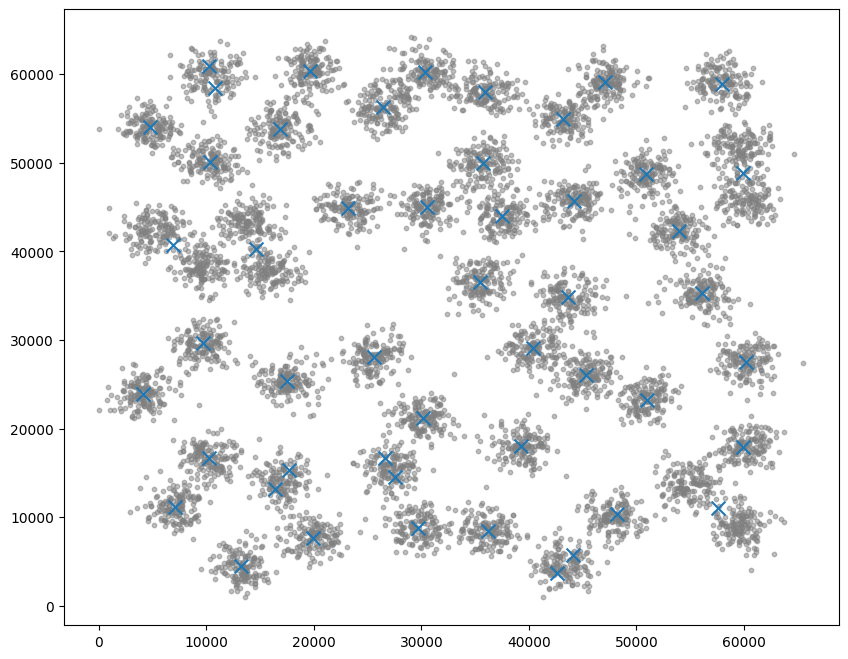

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

plot_data = np.array(parsed_data.collect())

# Plot raw data points
plt.scatter(
    plot_data[:, 0], plot_data[:, 1], 
    s=10, alpha=0.5, label="Raw Data", color='gray'
)

plt.scatter(
    final_group[0][:, 0], final_group[0][:, 1], 
    label=f"Centroids Group", 
    marker='x', s=100
)

In [40]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

data = np.array(parsed_data.collect())
kmeans = KMeans(n_clusters=k, max_iter=max_iterations, random_state=314)
cluster_labels = kmeans.fit_predict(data)

# Evaluate using Silhouette Score
silhouette = silhouette_score(data, cluster_labels)
silhouette

np.float64(0.5730469700246406)

In [41]:
centroid_to_point = parsed_data.map(
    lambda point: (
        np.argmin([np.linalg.norm(point - c) for c in final_group[0]]), # cluster_id
        point # original point
    )
).collect()

cluster_labels, data = zip(*centroid_to_point)
silhouette = silhouette_score(data, cluster_labels)
silhouette